In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt

In [3]:
df = web.DataReader('GOOGL', 'yahoo', start='2003-01-01', end='now')

In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-13,2263.469971,2243.050049,2250.989990,2254.429932,1284100.0,2254.429932
2021-04-14,2267.429932,2236.020020,2267.429932,2241.909912,1050100.0,2241.909912
2021-04-15,2296.000000,2251.169922,2261.949951,2285.250000,1458700.0,2285.250000
2021-04-16,2294.239990,2270.919922,2289.239990,2282.750000,1313600.0,2282.750000
2021-04-19,2304.084961,2270.179932,2270.179932,2287.209961,970650.0,2287.209961


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4195 entries, 2004-08-19 to 2021-04-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       4195 non-null   float64
 1   Low        4195 non-null   float64
 2   Open       4195 non-null   float64
 3   Close      4195 non-null   float64
 4   Volume     4195 non-null   float64
 5   Adj Close  4195 non-null   float64
dtypes: float64(6)
memory usage: 229.4 KB


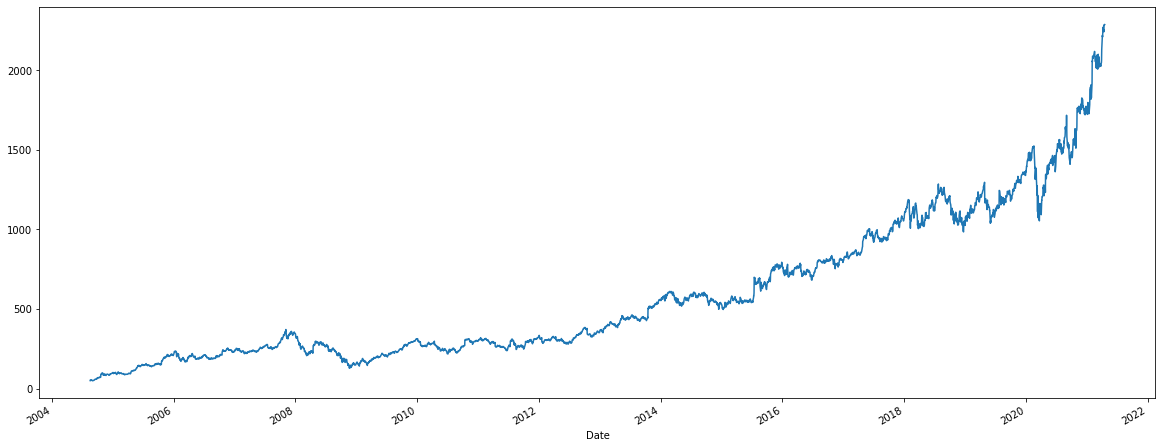

In [6]:
df['Close'].plot(figsize=(20,8))

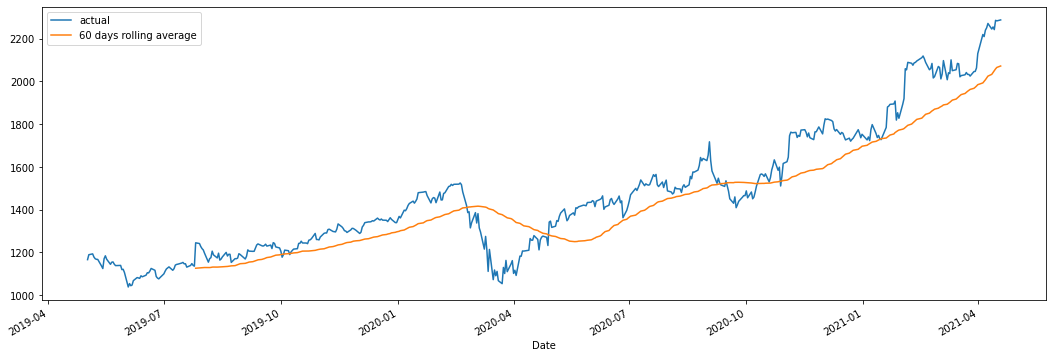

In [7]:
df2 = df.iloc[3700:]
df2['Close'].plot(figsize=(18,6), label="actual")
df2.rolling(60).mean()['Close'].plot(label='60 days rolling average')
plt.legend()

Here starts the all kinds of different regression models as benchmarks to the Deep Learning RNN model

In [25]:
# import sklearn related modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [13]:
df.to_csv('stock_Google.csv')

In [14]:
df_bench = pd.read_csv('stock_Google.csv')

In [16]:
times = pd.to_datetime(df_bench.loc[:,'Date']).astype(np.int64) // (10**9)

In [17]:
X_bench = times.values.reshape(-1,1)

In [18]:
y_bench = df_bench.loc[:,'Close'].values.reshape(-1,1)

In [21]:
validation_size = 0.15
seed = 11
X_train_bench, X_validation_bench, y_train_bench, y_validation_bench = train_test_split(X_bench, y_bench, test_size=validation_size, random_state=seed)

In [22]:
# Test options and evaluation metric
num_folds = 20
seed = 11
scoring = "r2"
# list for different traditional models
models = []
models.append((' LR ', LinearRegression()))
models.append((' CART ', DecisionTreeRegressor()))
models.append((' SVR ', SVR()))
models

[(' LR ',
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)),
 (' CART ',
  DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best')),
 (' SVR ',
  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
      kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]

In [24]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_bench, y_train_bench, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

 LR : 0.821653 (0.018659)
 CART : 0.999111 (0.000305)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

 SVR : 0.844230 (0.029382)


Which means the decision tree model performs best, so we would choose that, and also take a look at the linear regression model

In [26]:
# Define models
model_tree = DecisionTreeRegressor()
model_linear = LinearRegression()
# trainning
model_tree.fit(X_train_bench, y_train_bench)
model_linear.fit(X_train_bench, y_train_bench)
# predictions based on the whole dataset
predictions_tree = model_tree.predict(X_bench)
predictions_linear = model_linear.predict(X_bench)
print(mean_squared_error(y_bench, predictions_tree))
print(mean_squared_error(y_bench, predictions_linear))

19.725400896818584
35548.27690473474


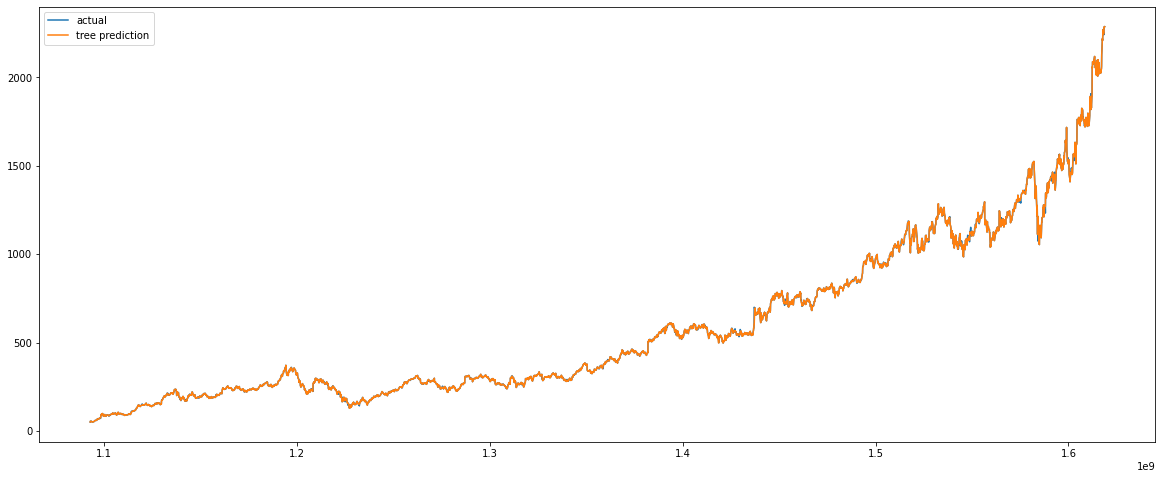

In [29]:
# compare plots of the actual prices with predictions on both trainning and testing data(randomized)
fig= plt.figure(figsize=(20,8))
plt.plot(X_bench,y_bench, label='actual')
plt.plot(X_bench,predictions_tree, label='tree prediction')
plt.legend()
plt.show()

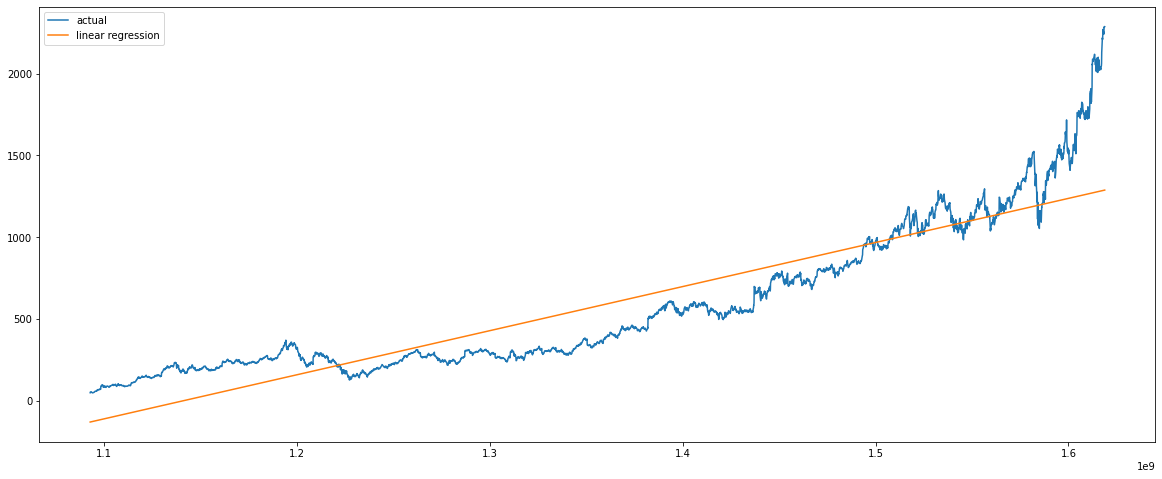

In [30]:
# compare plots of the actual prices with predictions on both trainning and testing data(randomized)
fig= plt.figure(figsize=(20,8))
plt.plot(X_bench,y_bench, label='actual')
plt.plot(X_bench,predictions_linear, label='linear regression')
plt.legend()
plt.show()

But what if we don't mix the time-series data? But the past as trainning while the future as testing?

In [32]:
train_size = 4000
X_train_bench, X_test_bench = X_bench[:train_size,:], X_bench[train_size:,:]
y_train_bench, y_test_bench = y_bench[:train_size,:], y_bench[train_size:,:]

In [33]:
# Define models
model_tree = DecisionTreeRegressor()
model_linear = LinearRegression()
# trainning
model_tree.fit(X_train_bench, y_train_bench)
model_linear.fit(X_train_bench, y_train_bench)
# predictions based on the whole dataset
predictions_tree = model_tree.predict(X_bench)
predictions_linear = model_linear.predict(X_bench)
print(mean_squared_error(y_bench, predictions_tree))
print(mean_squared_error(y_bench, predictions_linear))

5404.133196081447
38625.04085388988


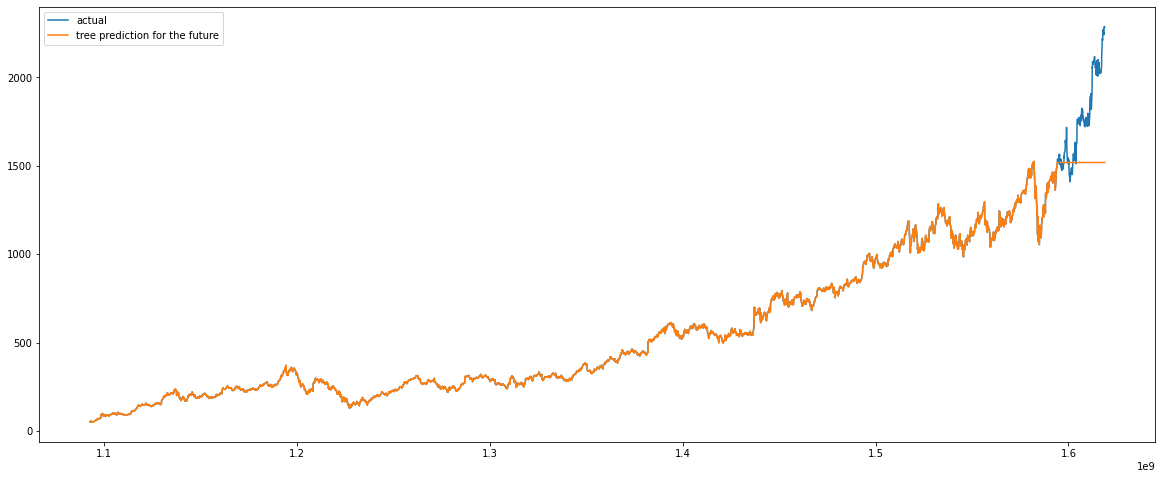

In [34]:
# compare plots of the actual prices with predictions on both trainning and testing data(randomized)
fig= plt.figure(figsize=(20,8))
plt.plot(X_bench,y_bench, label='actual')
plt.plot(X_bench,predictions_tree, label='tree prediction for the future')
plt.legend()
plt.show()

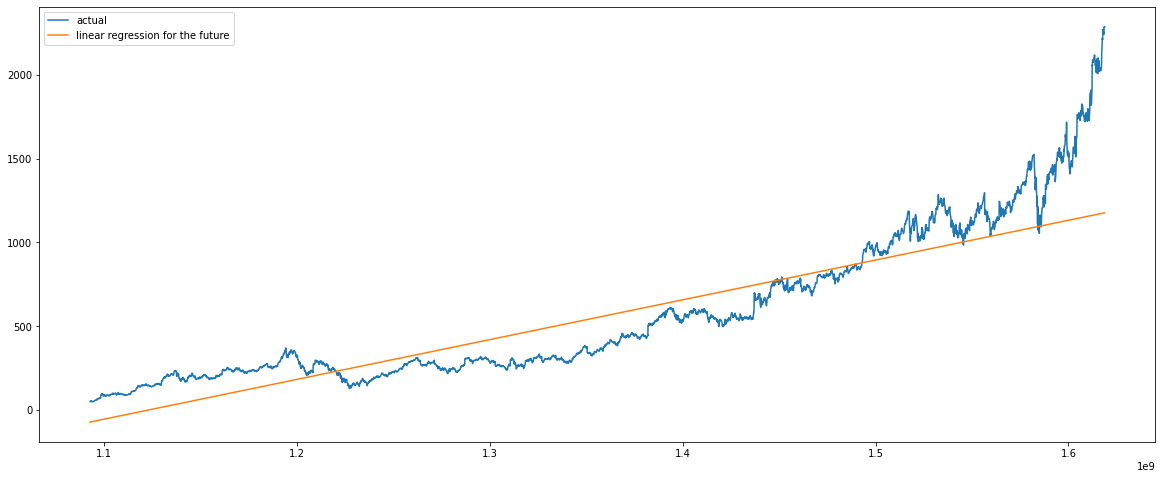

In [35]:
fig= plt.figure(figsize=(20,8))
plt.plot(X_bench,y_bench, label='actual')
plt.plot(X_bench,predictions_linear, label='linear regression for the future')
plt.legend()
plt.show()

Now I will go ahead and train LSTM-based RNN model using Keras and see how it compares to the benchmarked traditional models

In [36]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [37]:
# First prepare and preprocess the input data, since LSTM models are sensive to the values
scaler = MinMaxScaler(feature_range=(0, 1))
my_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [38]:
# this creating feature function is critical, showing LSTM remembers the past!
def create_feature(data, days):
    X, y = [], []
    for i in range(days, len(data)):
        X.append(data[i-days:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [130]:
days= 180
X, y = create_feature(my_data, days)

In [131]:
y.shape

(4015,)

In [85]:
train_size = 3500
X_train, X_test = X[:train_size,:], X[train_size:,:]
y_train, y_test = y[:train_size], y[train_size:]

In [86]:
y_test[:5]

array([0.45855787, 0.46278196, 0.46111915, 0.45985859, 0.45343973])

In [48]:
y_test.shape

(575,)

In [88]:
# reshape X and y train so it fit to the input data for Tensorflow
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(-1,1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(-1,1)

In [52]:
def create_RNN(shape, units):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=shape))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(LSTM(units=units))
    model.add(Dense(units=1))
    return model

In [54]:
# creatiing model
my_model = create_RNN((X_train.shape[1],1), 50)

# compiling RNN
my_model.compile(optimizer='adam', loss='mean_squared_error')


In [55]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [56]:
# train the model
my_model.fit(X_train,y_train,epochs=200, batch_size=32)

Epoch 1/200
110/110 [==============================] - 22s 155ms/step - loss: 0.0067
Epoch 2/200
110/110 [==============================] - 18s 163ms/step - loss: 1.0647e-04
Epoch 3/200
110/110 [==============================] - 18s 163ms/step - loss: 1.1262e-04
Epoch 4/200
110/110 [==============================] - 18s 163ms/step - loss: 1.0996e-04
Epoch 5/200
110/110 [==============================] - 18s 163ms/step - loss: 1.0553e-04
Epoch 6/200
110/110 [==============================] - 18s 164ms/step - loss: 9.1313e-05
Epoch 7/200
110/110 [==============================] - 18s 162ms/step - loss: 1.0489e-04
Epoch 8/200
110/110 [==============================] - 18s 162ms/step - loss: 8.9190e-05
Epoch 9/200
110/110 [==============================] - 18s 164ms/step - loss: 8.8833e-05
Epoch 10/200
110/110 [==============================] - 18s 165ms/step - loss: 8.6841e-05
Epoch 11/200
110/110 [==============================] - 18s 165ms/step - loss: 1.0562e-04
Epoch 12/200
110/110 [=

In [89]:
test_pred = my_model.predict(X_test)

In [91]:
smse = np.sqrt(mean_squared_error(y_test,test_pred))
print(smse)

0.02268463886067224


In [93]:
test_pred_back = scaler.inverse_transform(test_pred)
y_test_back =scaler.inverse_transform(y_test)
relate_diff = abs(np.sum(test_pred_back-y_test_back))/np.sum(y_test_back[:,0])
print(relate_diff)

0.01874442475476819


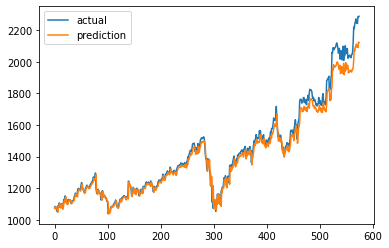

In [67]:
plt.plot(df['Close'].values[train_size+days:], label="actual")
plt.plot(test_pred, label='prediction')
plt.legend()

In [124]:
# Now this important function is used to predict the "unknown" future
def predict_future(model,future_day,input_X):
    theshape = input_X.shape
    if future_day == 1:
        pred = model.predict(input_X)
        return scaler.inverse_transform(pred)[:,0]
    output = []
    for day in range(future_day):
        if day == future_day - 1:
            pred = model.predict(input_X)
            pred_inverse = scaler.inverse_transform(pred)[:,0]
            output.append(pred_inverse.tolist())
        else:
            pred = model.predict(input_X)        
            pred_inverse = scaler.inverse_transform(pred)[:,0]
            output.append(pred_inverse.tolist())
            input_X = np.append(input_X[:,1:,:],pred).reshape(theshape)

    return np.array(output)

In [132]:
X_train_future = X.reshape(X.shape[0], X.shape[1], 1)
y_train_future = y.reshape(-1,1)

In [137]:
# creatiing model
my_model_future = create_RNN((X_train_future.shape[1],1), 50)

# compiling RNN
my_model_future.compile(optimizer='adam', loss='mean_squared_error')

In [138]:
# train the model
my_model_future.fit(X_train_future,y_train_future,epochs=100, batch_size=32)

Epoch 1/100
126/126 [==============================] - 34s 230ms/step - loss: 0.0104
Epoch 2/100
126/126 [==============================] - 31s 243ms/step - loss: 3.0101e-04
Epoch 3/100
126/126 [==============================] - 31s 243ms/step - loss: 2.5007e-04
Epoch 4/100
126/126 [==============================] - 30s 242ms/step - loss: 3.1054e-04
Epoch 5/100
126/126 [==============================] - 31s 245ms/step - loss: 2.5282e-04
Epoch 6/100
126/126 [==============================] - 31s 248ms/step - loss: 2.3910e-04
Epoch 7/100
126/126 [==============================] - 31s 250ms/step - loss: 1.9267e-04
Epoch 8/100
126/126 [==============================] - 31s 247ms/step - loss: 2.1518e-04
Epoch 9/100
126/126 [==============================] - 31s 249ms/step - loss: 1.6031e-04
Epoch 10/100
126/126 [==============================] - 31s 248ms/step - loss: 1.8265e-04
Epoch 11/100
126/126 [==============================] - 31s 246ms/step - loss: 1.7879e-04
Epoch 12/100
126/126 [=

In [151]:
days = 180
X_future = X_train_future[-1,:,:].reshape(1,days,1)
d_future = 1
my_pred = predict_future(my_model_future,d_future,X_future)
print(my_pred)

[2311.4888]


In [152]:
days = 180
X_future = X_train_future[-1,:,:].reshape(1,days,1)
d_future = 7
my_pred = predict_future(my_model_future,d_future,X_future)
print(my_pred)

[[2311.48876953]
 [2336.20483398]
 [2358.8671875 ]
 [2379.64208984]
 [2398.94189453]
 [2417.18164062]
 [2434.62329102]]


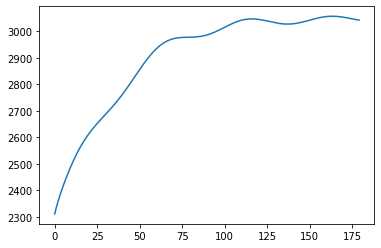

In [155]:
d_future = 180
my_pred = predict_future(my_model_future,d_future,X_future)
plt.plot(my_pred)

In [156]:
df = web.DataReader('MSFT', 'yahoo', start='2003-01-01', end='now')

In [157]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2003-01-02,26.875000,25.855000,26.150000,26.860001,67025200.0,17.060148
2003-01-03,26.900000,26.440001,26.795000,26.895000,55546800.0,17.082380
2003-01-06,27.615000,26.900000,27.010000,27.385000,59456200.0,17.393604
2003-01-07,28.004999,27.340000,27.459999,27.900000,80517400.0,17.720707
2003-01-08,27.775000,27.055000,27.684999,27.120001,64566000.0,17.225286


In [158]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-13,259.190002,256.829987,257.260010,258.489990,23837500.0,258.489990
2021-04-14,258.829987,255.160004,257.480011,255.589996,23070900.0,255.589996
2021-04-15,259.929993,257.730011,257.929993,259.500000,25627500.0,259.500000
2021-04-16,261.000000,257.600006,259.470001,260.739990,24856900.0,260.739990
2021-04-19,261.480011,257.821014,260.190002,258.739990,21470615.0,258.739990


In [159]:
scaler = MinMaxScaler(feature_range=(0, 1))
my_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [160]:
days= 180
X, y = create_feature(my_data, days)

In [161]:
X_train_future = X.reshape(X.shape[0], X.shape[1], 1)
y_train_future = y.reshape(-1,1)

In [162]:
# creatiing model
my_model_future = create_RNN((X_train_future.shape[1],1), 50)

# compiling RNN
my_model_future.compile(optimizer='adam', loss='mean_squared_error')

In [163]:
my_model_future.fit(X_train_future,y_train_future,epochs=50, batch_size=32)

Epoch 1/50
139/139 [==============================] - 38s 237ms/step - loss: 0.0060
Epoch 2/50
139/139 [==============================] - 34s 248ms/step - loss: 2.1506e-04
Epoch 3/50
139/139 [==============================] - 35s 249ms/step - loss: 2.0827e-04
Epoch 4/50
139/139 [==============================] - 35s 250ms/step - loss: 2.6571e-04
Epoch 5/50
139/139 [==============================] - 35s 250ms/step - loss: 1.8478e-04
Epoch 6/50
139/139 [==============================] - 35s 251ms/step - loss: 2.2242e-04
Epoch 7/50
139/139 [==============================] - 35s 253ms/step - loss: 1.6086e-04
Epoch 8/50
139/139 [==============================] - 35s 253ms/step - loss: 1.9193e-04
Epoch 9/50
139/139 [==============================] - 35s 249ms/step - loss: 1.7503e-04
Epoch 10/50
139/139 [==============================] - 35s 249ms/step - loss: 1.5803e-04
Epoch 11/50
139/139 [==============================] - 35s 252ms/step - loss: 1.2546e-04
Epoch 12/50
139/139 [=============

In [164]:
X_future = X_train_future[-1,:,:].reshape(1,days,1)
d_future = 1
my_pred = predict_future(my_model_future,d_future,X_future)
print(my_pred)

[254.99313]


In [165]:
d_future = 7
my_pred = predict_future(my_model_future,d_future,X_future)
print(my_pred)

[[254.99313354]
 [249.824646  ]
 [244.74021912]
 [240.2323761 ]
 [236.31678772]
 [232.8571167 ]
 [229.67599487]]


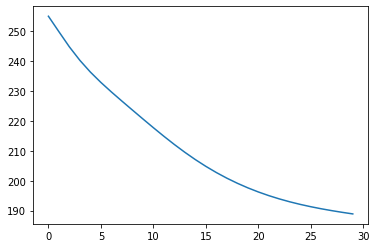

In [169]:
d_future = 30
my_pred = predict_future(my_model_future,d_future,X_future)
plt.plot(my_pred)

In [170]:
df = web.DataReader('SHOP', 'yahoo', start='2003-01-01', end='now')

In [171]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-05-20,17.000000,17.000000,17.000000,17.000000,0,17.000000
2015-05-21,28.740000,24.110001,28.000000,25.680000,12303900,25.680000
2015-05-22,31.100000,26.000000,26.070000,28.309999,2841200,28.309999
2015-05-26,30.340000,29.080000,29.799999,29.650000,820200,29.650000
2015-05-27,30.809999,27.000000,30.670000,27.500000,797600,27.500000


In [172]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-13,1248.209961,1215.050049,1215.050049,1241.540039,1092300,1241.540039
2021-04-14,1250.000000,1176.020020,1248.000000,1179.859985,1316500,1179.859985
2021-04-15,1221.969971,1187.000000,1200.000000,1208.339966,954500,1208.339966
2021-04-16,1219.189941,1187.819946,1211.000000,1207.800049,733700,1207.800049
2021-04-19,1202.050049,1143.599976,1192.000000,1145.780029,899607,1145.780029


In [173]:
scaler = MinMaxScaler(feature_range=(0, 1))
my_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [174]:
my_data.shape

(1489, 1)

In [175]:
days= 90
X, y = create_feature(my_data, days)

In [176]:
X_train_future = X.reshape(X.shape[0], X.shape[1], 1)
y_train_future = y.reshape(-1,1)

In [177]:
# creatiing model
my_model_future = create_RNN((X_train_future.shape[1],1), 50)

# compiling RNN
my_model_future.compile(optimizer='adam', loss='mean_squared_error')

In [178]:
my_model_future.fit(X_train_future,y_train_future,epochs=50, batch_size=32)

Epoch 1/50
44/44 [==============================] - 10s 118ms/step - loss: 0.0251
Epoch 2/50
44/44 [==============================] - 5s 118ms/step - loss: 0.0011
Epoch 3/50
44/44 [==============================] - 5s 115ms/step - loss: 0.0012
Epoch 4/50
44/44 [==============================] - 5s 117ms/step - loss: 8.2895e-04
Epoch 5/50
44/44 [==============================] - 5s 116ms/step - loss: 0.0010
Epoch 6/50
44/44 [==============================] - 5s 116ms/step - loss: 8.3732e-04
Epoch 7/50
44/44 [==============================] - 5s 116ms/step - loss: 0.0011
Epoch 8/50
44/44 [==============================] - 5s 121ms/step - loss: 0.0011
Epoch 9/50
44/44 [==============================] - 5s 119ms/step - loss: 7.3063e-04
Epoch 10/50
44/44 [==============================] - 5s 122ms/step - loss: 6.6733e-04
Epoch 11/50
44/44 [==============================] - 5s 123ms/step - loss: 5.9291e-04
Epoch 12/50
44/44 [==============================] - 5s 125ms/step - loss: 6.7970e-04


In [179]:
X_future = X_train_future[-1,:,:].reshape(1,days,1)
d_future = 1
my_pred = predict_future(my_model_future,d_future,X_future)
print(my_pred)

[1244.2616]


In [180]:
d_future = 7
my_pred = predict_future(my_model_future,d_future,X_future)
print(my_pred)

[[1244.26159668]
 [1273.421875  ]
 [1304.23254395]
 [1332.32434082]
 [1357.21069336]
 [1378.60241699]
 [1396.48986816]]


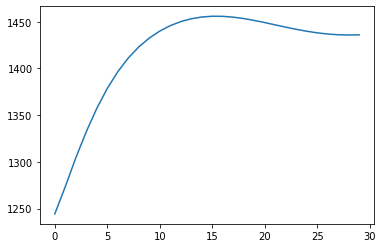

In [181]:
d_future = 30
my_pred = predict_future(my_model_future,d_future,X_future)
plt.plot(my_pred)